In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [16]:
import os
import librosa
import librosa.display
import scipy.constants as const
import scipy
import IPython.display
from scipy.io import wavfile
from IPython.core.display import HTML
from __future__ import division
from tensorflow.python.platform import gfile

In [97]:
PATH_TEST = "./dataset/test"
PATH_TRAINING = "./dataset/train"
os.listdir(PATH_TRAINING)

['a', 'e', 'i', 'o', 'ou', 'u', 'znone']

In [84]:
path = os.path.join(PATH_TRAINING, "znone", "*.wav")
wave_path = gfile.Glob(path)[0]
IPython.display.Audio(wave_path)

In [93]:
wave, sr = librosa.load(wave_path, mono=True, offset=0.5, duration=0.125)
wave.shape

(2756,)

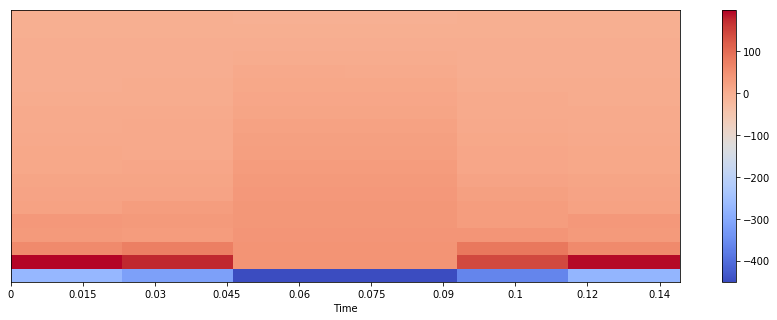

In [94]:
mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=20)
plt.figure(figsize=(15,5))
plt.title = "MFCC"
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()

In [96]:
mfccs

array([[-2.70498065e+02, -3.16595012e+02, -4.50119300e+02,
        -4.50085046e+02, -3.61899040e+02, -2.76250582e+02],
       [ 1.98482298e+02,  1.75688653e+02,  4.47194451e+01,
         4.47626685e+01,  1.43029209e+02,  1.95531469e+02],
       [ 5.94917985e+01,  7.57143724e+01,  4.40339942e+01,
         4.40618013e+01,  8.67211589e+01,  6.12181449e+01],
       [ 3.39376499e+01,  3.30620968e+01,  4.29062883e+01,
         4.29091949e+01,  4.37875550e+01,  3.38990194e+01],
       [ 3.73527109e+01,  3.49273465e+01,  4.13579686e+01,
         4.13276410e+01,  3.03924138e+01,  3.73603503e+01],
       [ 2.25720293e+01,  2.98088153e+01,  3.94184937e+01,
         3.93481306e+01,  3.02886844e+01,  2.32542276e+01],
       [ 1.98725617e+01,  1.92641989e+01,  3.71243347e+01,
         3.70089758e+01,  2.61673599e+01,  1.98009195e+01],
       [ 1.69904580e+01,  1.74308693e+01,  3.45179887e+01,
         3.43547357e+01,  1.86739698e+01,  1.73233550e+01],
       [ 1.13655759e+01,  1.55680231e+01,  3.164